In [81]:
''' Implementation of Fast Fourier Transform (FFT), inverse FFT and Discrete Fourier Transform (DFT) '''
import sys
from math import log
import numpy as np
from scipy.fft import fftn,ifftn
from matplotlib import pyplot as plt
import cv2 as cv
import time
import timeit

In [82]:
def fftComplex(f,inverse=False):
    '''
    Implementation of Fast Fourier Transform and Inverse Fast Fourier Transform.
    Input : f            -> time series (1-D array)
            inverse      -> False, if FFT calculation
                            True, if inverse FFT calculation
    Output: outputSeries -> Fourier transform of f (in the complex number form), if inverse = False
                            Inverse Fourier transform of f, if inverse = True
    Assumption: Length of f is 2^k, where k is a positive integer. 
    '''
    N=len(f)                   # Length of the power series
    if N == 1:
        return f
    height=log(N,2)            # Getting the power of 2 of the length
    h=int(height)
    if height-h > 0:           # Checking if the dimension is a power of 2
        sys.exit("The dimensions of the series are not powers of 2")
   
    ## Arrange initial pairs to calculate fft
    tempSeries=[None for i in range(N)]
    for i in range(N):
        if tempSeries[i] is None:
            reverseBits=int(bin(i)[2:].zfill(h)[-1::-1],2)
            if i == reverseBits:
                tempSeries[i]=f[i]
            else:
                tempSeries[reverseBits]=f[i]
                tempSeries[i]=f[reverseBits]

    outputSeries=[None for i in range(N)]
    ## Calculate fft for pairs of higher orders until the wavelength of the series becomes equal to the input series
    for m in range(1,h+1):                       # starting with wavelength 2^1=2 calculate till 2^h=N
        waveLength=2**(m-1)
        ## Decide w_2M based on if it is FFT function or inverse FFT
        if inverse == True:
            w=np.e ** (1j*np.pi/(waveLength))  # epsilon for inverse FT
        else:
            w=np.e ** (-1j*np.pi/(waveLength)) # epsilon for FT
    
        for n in range(0,N,2*waveLength):
            for step in range(waveLength):
                outputSeries[n+step]=(tempSeries[n+step]+tempSeries[n+step+waveLength]*(w**step))/2
                outputSeries[n+step+waveLength]=(tempSeries[n+step]-tempSeries[n+step+waveLength]*(w**step))/2
        tempSeries=outputSeries[:]
    
    return outputSeries    

In [83]:
def fftImage(img,inverse=False):
    '''
    Implementation of Fast Fourier Transform for a 2-D image.
    Input image: img (grey image)
                 inverse = False for FFT , img is a real grey image.
                           True for IFFT, img is a fourier image
    Output : oimg (fourier transform image with complex coefficients, if inverse = False
                   real image, if inverse = True)
    Assumption: Dimensions of input image is M x N, 
                where M and N are of the form 2^k, k is a positive integer.     
    '''
    row,col=img.shape
    for i in range(row):
        rowFFT=fftComplex(img[i],inverse)
        if i == 0:
            oimg=rowFFT
        else:
            oimg=np.vstack([oimg,rowFFT])
    for i in range(col):
        oimg[:,i]=fftComplex(oimg[:,i],inverse)
    
    return oimg

In [84]:
def createU(n,inverse=False):
    '''
    Create U matrix for DFT
    '''
    U=np.zeros((n,n),dtype=complex)
    if inverse == True:
        eps=np.e**(2j*np.pi/n)
    else:
        eps=np.e**(-2j*np.pi/n)
    
    for i in range(n):
        for j in range(n):
            U[i,j]=eps**(i*j)
    return (U/n)


In [85]:
def dftImage(img,inverse=False):
    '''
    Implementation of Discrete Fourier Transform for a 2-D image.
    Input image: img (grey image)
                 inverse = False for DFT , img is a real grey image.
                           True for IDFT, img is a fourier image
    Output     : oimg (fourier transform image with complex coefficients, if inverse = False
                       real image, if inverse = True)
    Assumption: Input image is a square image
    '''
    m,n=img.shape
    
    U=createU(n,inverse)
    if m == n:
        oimg=np.linalg.multi_dot([U,img,U])
    else:
        V=createU(m,inverse)
        oimg=np.linalg.multi_dot([V,img,U])

    return oimg

In [86]:
def circshift(img,x=None,y=None):
    '''
    Rolls an image on both horizontal and vertical directions 
    '''
    m,n=img.shape
    if x is None:
        x=m//2
    if y is None:
        y=n//2
    oimg=np.zeros(img.shape,dtype=np.complex)
    for i in range(m):
        ti=(i+x)%m
        for j in range(n):
            tj=(j+y)%n
            oimg[ti,tj]=img[i,j]
    return oimg

In [87]:
def scaleImg4Display(img):
    '''
    This function takes logarithm for better display of fourier spectrum, and also adjusts min and max values to 0 and 255 
    '''
    oimg=np.zeros(img.shape,dtype=np.float16)  # initialise output
    pimg=np.log(1+np.abs(img))                 # take log of the magnitude. Added 1 to avoid log 0 error
    minv=np.min(pimg)                          
    maxv=np.max(pimg)
    if maxv==minv:
        return pimg
    else:
        oimg=(pimg-minv)*255/(maxv-minv)
        return oimg

In [88]:
def fftshift1(img):
    '''
    Implementation of creating fourier magnitude spectrum of an image.
    Input:  img -> Spatial gray image (2D)
    Output: smg -> Fourier Magnitude Spectrum with same size as input
    '''
    smg=circshift(img)
    smg=np.log(1+np.abs(smg))
    return scaleImg4Display(smg)

In [89]:
def calcGoodSize(n):
    '''
    Returns nearest number in the form 2**m, given a number n
    '''
    i=0
    while(True):
        N=2**i
        if N < n:
            i += 1
        elif N > n:
            if (N - n) > (n-2**(i-1)):
                return 2**(i-1)
            else:
                return N
        else:
            return N

Scipy FFT run time: 0.015634536743164062
My FFT run time: 13.074767827987671
My DFT run time: 0.26265525817871094


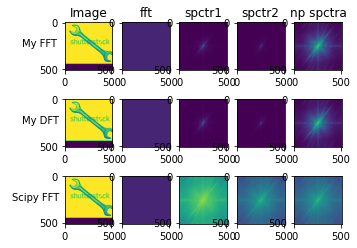

In [90]:
# Creation of image, that will be the input of Fast Fourier Transform implemented from scratch.
'''
N=16
M=16

ff=np.zeros([M,N])
ff[0,0]=1

img=ifftn(ff)
img1=fftImage(ff,True) # Calculate inverse FFT using the implemented FFT function, 2nd parameter is True for inverse function
img2=dftImage(ff,True) # Calculate IDFT using the implemented DFT function, 2nd parameter is True for inverse function


'''
## Reading spatial image from inout for testing
img=cv.imread("Tool.PNG")  # read image
l=len(img.shape)     
if l==2:                   # consider only B channel, if image is not grey
    m,n=img.shape
elif l>2:
    m,n=img.shape[:2]
    img=img[:,:,0]
else:
    sys.exit("Image should be atleat 2 dimension")

M=calcGoodSize(m)        # calculate nearest dimensions of the form 2**N
N=calcGoodSize(n)

if M < m:                # if image is bigger, crop it to a dimension of 2**N
    img=img[:M,:]
if N < n:
    img=img[:,:N]
if M > m:                # if image is smaller, then pad with zeros to make dimension 2**N
    img=np.vstack([img,np.zeros([M-m,img.shape[1]])])
if N > n:
    img=np.hstack([img,np.zeros([img.shape[0],N-n])])

img1=img2=img


# Create fourier magnitude spectrum: multiply input image with (-1)^(x+y), x= row, y=col and then do FFT.
a=[(-1)**i for i in range(N)]       # create mask for the multiplication (-1)^(x+y) 
b=[a[::(-1)**i] for i in range(M)]
msk=np.array(b)

mimg=img*msk                   # mask * image to have effect of multiplication with (-1)^(x+y)
mimg1=img1*msk 
mimg2=img2*msk 

# Apply scipy FFT on the image
stime=time.time()
x=fftn(img)
etime=time.time()
print('Scipy FFT run time:', etime-stime)
mx=fftn(mimg)

# Apply implemented FFT on the image
stime=time.time()
imgfft=fftImage(img1)
etime=time.time()
print('My FFT run time:', etime-stime)
mimgfft=fftImage(mimg1)

# Apply implemented DFT on the image
stime=time.time()
imgdft=dftImage(img2)
etime=time.time()
print('My DFT run time:', etime-stime)
mimgdft=dftImage(mimg2)

# Create Fourier magnitude spectrum for all FT images
imgfftSpectrum1=fftshift1(imgfft)
imgfftSpectrum3=scaleImg4Display(mimgfft)
imgShift1=fftshift1(imgfft)
imgfftSpectrum2=scaleImg4Display(imgShift1)

imgdftSpectrum1=fftshift1(imgdft)
imgdftSpectrum3=scaleImg4Display(mimgdft)
imgShift2=fftshift1(imgdft)
imgdftSpectrum2=scaleImg4Display(imgShift2)

imgxSpectrum1=fftshift1(x)
imgxSpectrum3=scaleImg4Display(mx)
imgShiftx=np.fft.fftshift(x)
imgxSpectrum2=scaleImg4Display(imgShiftx)

# Plot spatial image, implemented FFT image and the scipy FFT image. for comparison
plt.clf

row=3
col=6
offset=1

plt.subplot(row,col,offset)
plt.text(0.3,0.5,'My FFT')
plt.axis('off')

plt.subplot(row,col,col+offset)
plt.text(0.3,0.5,'My DFT')
plt.axis('off')

plt.subplot(row,col,2*col+offset)
plt.text(0.1,0.5,'Scipy FFT')
plt.axis('off')

offset += 1
plt.subplot(row,col,offset)
plt.imshow(np.real(img1))
plt.title('Image')

plt.subplot(row,col,col+offset)
plt.imshow(np.real(img2))

plt.subplot(row,col,2*col+offset)
plt.imshow(np.real(img))

offset += 1
plt.subplot(row,col,offset)
plt.imshow(np.real(imgfft))
plt.title('fft')

plt.subplot(row,col,col+offset)
plt.imshow(np.real(imgdft))

plt.subplot(row,col,2*col+offset)
plt.imshow(np.real(x))

offset += 1
plt.subplot(row,col,offset)
plt.imshow(imgfftSpectrum1)
plt.title('spctr1')

plt.subplot(row,col,col+offset)
plt.imshow(imgdftSpectrum1)

plt.subplot(row,col,2*col+offset)
plt.imshow(imgxSpectrum1)

offset += 1
plt.subplot(row,col,offset)
plt.imshow(imgfftSpectrum3)
plt.title('spctr2')

plt.subplot(row,col,col+offset)
plt.imshow(imgdftSpectrum3)

plt.subplot(row,col,2*col+offset)
plt.imshow(imgxSpectrum3)

offset += 1
plt.subplot(row,col,offset)
plt.imshow(imgfftSpectrum2)
plt.title('np spctra')

plt.subplot(row,col,col+offset)
plt.imshow(imgdftSpectrum2)

plt.subplot(row,col,2*col+offset)
plt.imshow(imgxSpectrum2)

plt.savefig("FFT_DFT_Spectrum.jpg")